In [1]:
import sys
print(sys.version,sys.executable)

3.11.5 (main, Sep 11 2023, 13:54:46) [GCC 11.2.0] /home/thu_huph22/miniconda3/envs/sumo/bin/python


# 如果提示缺少环境依赖，可以使用命令进行安装
`!pip install openpyxl`

In [2]:
import pandas as pd
sheet1 = pd.read_excel('公交数据.xlsx',sheet_name='刷卡数据',header=0,engine='openpyxl')
#线路编号	方向	站点编号	站点名称	日期	   刷卡数量
#1         1     1        火车站    2023-10-01  17
#print(sheet1.head())

sheet2 = pd.read_excel('公交数据.xlsx',sheet_name='站点数据',header=0,engine='openpyxl')
#	id	line_identity	line_direction	station_number	station_identity	station_name	longitude	latitude
#    1      1047               1              55                 1           碧海商业广场     106.618469  26.633052
#print(sheet2.head())

# 统计公交线路的基本信息

- 统计每个站点经过的线路
1. 不同站点经过的线路数是不一样的，所有站点累计经过6480条线路，每个站点平均经过线路数为6条。来回也算的话，大概三条
2. 暂无

In [3]:
station_line=sheet1.groupby('站点名称').agg({'线路编号':list}).reset_index()
#站点名称       线路编号
#(招呼站)	  [226, 226, 228]
#station_line.head()
#print(len(station_line))#1138
#实际经过了1138个站点，其中还有三个是站点表里面没有的。站点表里有1449个站点，加上这三个不在的站点。一共有1452个站点，
station_line['lines'] = station_line.apply(lambda x : len(x['线路编号']),axis=1)
#站点名称         线路编号           lines
#(招呼站)	  [226, 226, 228]          3
#print(sum(station_line['lines']))#6480

- 把所有的站点统计为字典，分为名字-id和id-名字两个映射
- 统计一下各条线路经过的站点量
1. 每条线路平均经过的站点数为：31.92.（因为贵阳的公交往返路线很多是不一致的，所以从起点到起点这个圈上所有经过的站点）
2. 线路总数为203条，线路经过的站点总数为6480，平均每条线路的站点数为：31.92站。（一圈）


In [4]:
#处理已知站点，不用地理位置信息，只根据流入流出确定
temp_station=sheet2.groupby('station_name').agg({'id':list}).reset_index()
# station_name                           id
#  (招呼站)             [7304, 7308, 7317, 7321, 10728, 10760]
#print(temp_station.head())
#把已知的站点信息统计一下
station_id={}
#station_name : id 
#(招呼站)     -> 0
for i in range(len(temp_station)):
    station_id[temp_station[i:i+1]['station_name'].values[0]]=i

print("station to id done")
#for key in station_id.keys():
#    print(key,'->',station_id[key])
#    break
id_station={}
#id -> station
#0 -> (招呼站)
for key,value in station_id.items():
    id_station[value]=key
print("id to station done")
#for key in id_station.keys():
#    print(key,'->',id_station[key])
#    break

#输出已知站点总数
#print(len(temp_station))#1449

line_station=sheet1.groupby('线路编号').agg({'站点名称':list}).reset_index()
#线路编号                        站点名称
#1         [火车站, 展览馆, 新路口, 邮电大楼, 大十字, 喷水池, 云中广场, 六广门, 北京路...
#print(line_station.head())
line_station['sites']=line_station.apply(lambda x:len(x['站点名称']),axis=1)
#线路编号                               站点名称                                       站点量
#1          [火车站, 展览馆, 新路口, 邮电大楼, 大十字, 喷水池, 云中广场, 六广门, 北京路...     18
#print(line_station.head())
#print(len(line_station))#203
#给每条线路上的每个站点一个编号
#print(sum(temp_line['sites']))#6480

station to id done
id to station done


- 把站点字典扩充一下，把实际节点中有的但是节点列表中没有的添加进去。

1. 实际线路一共有203条，实际节点1138个，站点列表中一共有1449个，其中有三个没涵盖。
2. 从线路上看总站点数为6480，而实际站点数只有1138.所以很多线路会有交叉，平均每个站点重用了6次，平均每条线路有31.92个站点。
3. 添加后的节点数为1452

In [5]:
#补充站点列表不包含的站点编号
not_contain= sheet1[~ sheet1['站点名称'].isin(station_id.keys())]
not_contain_station = not_contain.groupby('站点名称').agg({'刷卡数量':list}).reset_index()
for i in range(len(not_contain_station)):
    id_station[len(station_id)]=not_contain_station[i:i+1]['站点名称'].values[0]
    station_id[not_contain_station[i:i+1]['站点名称'].values[0]]=len(station_id)
#print(len(id_station))#1452


- 根据我们要构造的图的形式：节点和边（节点表示站点，同时由于两个站点之间可能有多条线路，为了区分线路，所以加上虚拟的线路站点。）
- 把公交的线路数据构造称为此站点，下站点，上车人数的形式。
- 然后对于每条此站点，下站点数据，做三项工作：1.向节点表中添加新的虚拟中间站点；2.同时创建邻接矩阵并添加两项，一项是起点到中转节点，另一项是中转到目标节点
- 3.在节点列表扩充完毕后，我们需要设计节点的特征，就用在各个节点的上车数据来表示：
- 边用节点特征表示，走什么线路，所以是稀疏矩阵不假，但是有些太大了，不过稀疏矩阵应该也好表示

In [6]:
#先按照此站下一站的关系聚个类
#统计一下线路-id-（站点，数量）的字典，构造为字典方便索引
#print(sheet1[sheet1['线路编号']==1])
#线路编号	方向	站点编号	站点名称	    日期	    刷卡数量
#1          1     1        火车站       2023-10-01    17
line_seq_stat_nums={}
for _ in range(len(sheet1)):
    line = sheet1[_:_+1]['线路编号'].values[0]
    sequence = sheet1[_:_+1]['站点编号'].values[0]
    station = sheet1[_:_+1]['站点名称'].values[0]
    nums = sheet1[_:_+1]['刷卡数量'].values[0]
    direction = sheet1[_:_+1]['方向'].values[0]
    if line not in line_seq_stat_nums:
        temp={sequence:(station,nums,direction)}
        line_seq_stat_nums[line]=temp
        continue
    if sequence not in line_seq_stat_nums[line]:
        line_seq_stat_nums[line][sequence]=(station,nums,direction)
        continue
#字典结构:{线路编号：{站点编号：(站点名称，刷卡数量，方向)}}
print("dict done")
#形成一个新的dataframe，结构为：[此站，下站，线路，刷卡数]
#可以使用join来构造，但是数据有问题，站点编号是不连续的，只能一行一行读取
this_next_line_nums=pd.DataFrame(columns=['此站','下站','线路','上车数量','此站编号','下站编号','单程终点'])
for line in line_seq_stat_nums.keys():
    sequen = list(line_seq_stat_nums[line].keys())
    sequen.sort()
    for index in range(len(sequen)):
        ll = {'此站':line_seq_stat_nums[line][sequen[index]][0],'下站':line_seq_stat_nums[line][sequen[(index+1)%len(sequen)]][0],'线路':line,'上车数量':line_seq_stat_nums[line][sequen[index]][1],'此站编号':sequen[index],'下站编号':sequen[(index+1)%len(sequen)],'单程终点':0 if line_seq_stat_nums[line][sequen[(index+1)%len(sequen)]][2]!=line_seq_stat_nums[line][sequen[index]][2] else 1}
        ##print(ll)
        #this_next_line_nums.append(ll,ignore_index=True)
        this_next_line_nums.loc[len(this_next_line_nums)]=ll
print("dataframe done")
#此站          下站    线路   上车数量  此站编号 下站编号 单程终点
#火车站       展览馆     1      17        1       2      1
#展览馆       新路口     1      318       2       3      1
#北京西路口  黔灵山公园   1      582       10      12      0
#print(this_next_line_nums[this_next_line_nums['线路']==1])

dict done
dataframe done


- 读取每行数据向站点列表中添加新站值，包括站点到id和id到站点，并创建一个邻接矩阵按行添加，起点终点
- 构造一个数据帧，重新记录一下从起点站去虚拟站的上车乘客量


In [7]:
neighbor_matrix=[]
#[[start,end]]
#[[7495,2348]]
this_middle_nums={}
#{'start':{'end':nums}}
#{'火车站': {'火车站_1_1_2_展览馆': 17}}
for row_index in range(len(this_next_line_nums)):
    line = this_next_line_nums[row_index:row_index+1]
    this_station=line['此站'].values[0]
    next_station=line['下站'].values[0]
    virtual_station=line['此站'].values[0]+'_'+str(line['此站编号'].values[0])+'_'+str(line['线路'].values[0])+'_'+str(line['下站编号'].values[0])+'_'+line['下站'].values[0]
    #station_id={}
    #station_name : id 
    #(招呼站)     -> 0
    #id_station={}
    #id -> station
    #0 -> (招呼站)
    if virtual_station not in station_id:
        id_station[len(station_id)]=virtual_station
        station_id[virtual_station]=len(station_id)
    neighbor_matrix.append([station_id[this_station],station_id[virtual_station]])
    neighbor_matrix.append([station_id[virtual_station],station_id[next_station]])
    if this_station not in this_middle_nums:
        this_middle_nums[this_station]={virtual_station:line['上车数量'].values[0]}
    else:
        this_middle_nums[this_station][virtual_station]=line['上车数量'].values[0]
#这样子我们既有了邻接矩阵，也有了实际的上车数量
print(len(station_id))

7932


- 上面的行运行完应该有了很多个新增虚拟站点，邻接矩阵不需要修改已经是准确的了，
- 但是站点的特征由于之前不知道有多少节点，所以站点特征不好写，但是现在可以解决了。

In [8]:
import numpy as np
station_features=np.zeros((len(station_id),len(station_id)),dtype=np.float64)
for i in range(len(station_id)):
    if id_station[i] in this_middle_nums:
        for middle in this_middle_nums[id_station[i]]:
            station_features[i,station_id[middle]]=float(this_middle_nums[id_station[i]][middle])#设置稀疏矩阵的第几行第几列为需要的值。
    else:
        continue

- 节点的特征都已经提取出来了，我们可以搭建模型了
- 损失函数还没构建呢，需要做一下损失函数的定义

In [9]:
#定义损失函数
def loss(predict_matrix,true_matrix):
    #预测矩阵中每一行流出的量求和应该等于实际流量中流入的量
    #row_sum = predict_matrix.sum(axis=0)
    #temp = predict_matrix+true_matrix
    #column_sum = temp.sum(axis=1)
    #temploss = sum((row_sum-column_sum)**2)/len(row_sum)
    
    temp = predict_matrix
    column_sum = temp.sum(axis=1)
    row_sum = true_matrix.sum(axis=0)
    temploss = (sum((row_sum-column_sum)**2)+sum((temp.sum(axis=1)-temp.sum(axis=0))**2))/len(row_sum)
    return temploss

In [10]:
#定义神经网络模型
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

from torch_geometric.data import Data
edge_index = torch.tensor(neighbor_matrix,dtype=torch.int64)
x=torch.as_tensor(station_features, dtype=torch.float)
data=Data(x=x,edge_index=edge_index.t().contiguous())

/home/thu_huph22/miniconda3/envs/sumo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
#网络定义
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(len(station_features[0]), 452)
        self.conv2 = GCNConv(452, 452)
        self.conv3 = GCNConv(452,len(station_features[0]))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        #print(x,edge_index)
        x = self.conv1(x=x, edge_index=edge_index)
        x = F.relu(x)
        x = self.conv2(x=x, edge_index=edge_index)
        x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        x = self.conv3(x=x, edge_index=edge_index)
        x = F.relu(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

#网络训练
model.train()
for epoch in range(2000):
    optimizer.zero_grad()
    out = model(data)
    #print(out,'\n',out.shape)
    loss_ = loss(out,data.x)
    loss_.backward()
    optimizer.step()
    if epoch%20==0:
        print(f"epoch:{epoch},loss:{loss_}")


epoch:0,loss:95856.0703125
epoch:20,loss:4096.087890625
epoch:40,loss:3988.4462890625
epoch:60,loss:3916.717529296875
epoch:80,loss:3883.086181640625
epoch:100,loss:3872.469970703125
epoch:120,loss:3861.813720703125
epoch:140,loss:3856.8037109375
epoch:160,loss:3849.549072265625
epoch:180,loss:3842.908447265625
epoch:200,loss:3837.7197265625
epoch:220,loss:3833.560791015625
epoch:240,loss:3830.197021484375
epoch:260,loss:3827.136474609375
epoch:280,loss:3823.25
epoch:300,loss:3820.604736328125
epoch:320,loss:3815.631103515625
epoch:340,loss:3812.577392578125
epoch:360,loss:3808.424560546875
epoch:380,loss:3804.647216796875
epoch:400,loss:3803.555908203125
epoch:420,loss:3803.827880859375
epoch:440,loss:3800.12353515625
epoch:460,loss:3796.8017578125
epoch:480,loss:3794.501220703125
epoch:500,loss:3792.3359375
epoch:520,loss:3789.76806640625
epoch:540,loss:3787.336669921875
epoch:560,loss:3785.816650390625
epoch:580,loss:3785.920166015625
epoch:600,loss:3778.301025390625
epoch:620,loss:

In [13]:
print(sum(out.sum(axis=0)))
print(sum(out.sum(axis=1)))
print(len(out[x!=0]))


tensor(32503.5312, device='cuda:0', grad_fn=<AddBackward0>)
tensor(32503.1719, device='cuda:0', grad_fn=<AddBackward0>)
6480


In [89]:
#定义损失函数
def newloss(predict_matrix,true_matrix):
    #预测矩阵中每一行流出的量求和应该等于实际流量中流入的量
    #row_sum = predict_matrix.sum(axis=0)
    temp = predict_matrix+true_matrix
    row_sum = temp.sum(axis=0)
    column_sum = temp.sum(axis=1)
    print("每个节点流出的量",row_sum,'\n',"每个节点流入的量",column_sum)
    loss = sum((row_sum-column_sum)**2)/len(row_sum)
    print(loss)

In [90]:
#从节点流出的量
newloss(out,x.to(device))
#从节点流入的量

每个节点流出的量 tensor([ 0.0000, 78.3572,  0.0000,  ...,  1.0000,  9.0609,  1.0000],
       device='cuda:0', grad_fn=<SumBackward1>) 
 每个节点流入的量 tensor([ 19.4564,  69.3199, 404.6872,  ...,  16.6872,  16.6872,  16.6872],
       device='cuda:0', grad_fn=<SumBackward1>)
tensor(4987.1382, device='cuda:0', grad_fn=<DivBackward0>)


# 可视化图结构

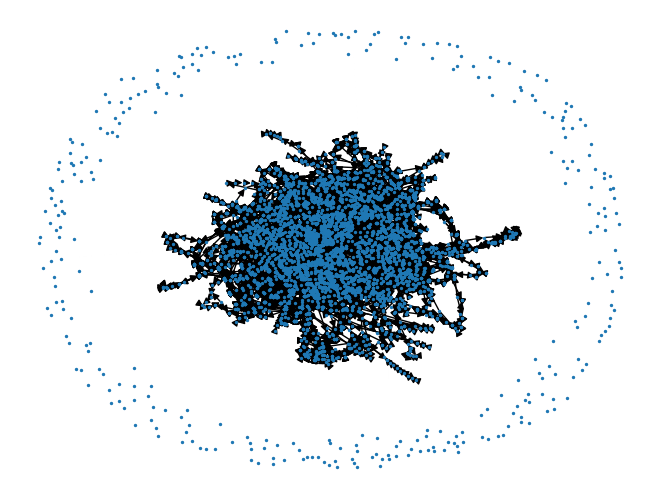

In [13]:
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
import networkx as nx
import torch_geometric
g = torch_geometric.utils.to_networkx(data,to_undirected=False)
nx.draw(g,node_size=2)
plt.show()

In [11]:
#统计下车数据
station_out = this_next_line_nums.groupby('此站').agg({'下站':list,'上车数量':list,'线路':list,'此站编号':list,'下站编号':list}).reset_index()
station_out

,此站,下站,上车数量,线路,此站编号,下站编号
0,(招呼站),"[113厂小区, 干井, 金华村]","[1, 1, 12]","[226, 226, 228]","[29, 33, 16]","[30, 34, 18]"
1,113厂小区,"[蒿机厂, 金华村, 悦城路口, 园区1号路]","[1, 7, 2, 54]","[226, 226, 227, 228]","[19, 30, 22, 19]","[25, 31, 25, 21]"
2,117地质队,"[温泉路口, 臣功路口, 温泉路口, 肉联厂, 万江机电, 温泉路口, 创业路, 温泉路口,...","[72, 7, 64, 21, 14, 25, 11, 121, 33, 20]","[56, 56, 234, 234, 246, 246, 252, 253, 253, 258]","[15, 51, 5, 31, 29, 38, 14, 6, 51, 14]","[16, 53, 6, 32, 31, 39, 15, 7, 52, 15]"
3,501厂宿舍区,"[北衙村, 红边路口]","[15, 3]","[605, 605]","[20, 29]","[21, 30]"
4,〇八三厂,"[旌德广场, 〇八三厂, 万江机电, 旌德广场, 景云山]","[4, 11, 2, 294, 7]","[234, 246, 246, 253, 253]","[1, 33, 34, 2, 55]","[2, 34, 36, 3, 1]"
...,...,...,...,...,...,...
1133,龙腾路(西),[棋苑街口],[5],[750],[22],[23]
1134,龙腾路东,"[双龙管委会, 兴业西路中, 市委党校, 双龙管委会, 轨道云盘站]","[78, 64, 2, 51, 26]","[46, 87, 216, 245, 811]","[4, 2, 8, 20, 2]","[5, 3, 10, 21, 3]"
1135,龙腾路口,[白腊山农场],[1],[805],[3],[5]
1136,龙里中学,[双龙路],[6],[803],[21],[24]


In [12]:
#统计图中有多少个节点，包括真实和虚拟
station_out['next_sum']=station_out.apply(lambda x:len(x['下站']),axis=1)
sum(station_out['next_sum'])+len(station_out)

7618

In [13]:
#校验一下看是不是这么多节点
print(this_next_line_nums)

         此站     下站    线路 上车数量 此站编号 下站编号 单程终点
0       火车站    展览馆     1   17    1    2    1
1       展览馆    新路口     1  318    2    3    1
2       新路口   邮电大楼     1  510    3    4    1
3      邮电大楼    大十字     1  678    4    5    1
4       大十字    喷水池     1  598    5    6    1
...     ...    ...   ...  ...  ...  ...  ...
6475   南垭路口    松花路  4005    2   10    4    0
6476    粑粑坳    粑粑坳  4600    2    7    7    1
6477  白金大道中    刚玉街  4601    1   14   16    1
6478    刚玉街  云环东路口  4601    1   16   18    1
6479  云环东路口  白金大道中  4601    1   18   14    1

[6480 rows x 7 columns]


In [81]:
#存入文件中
import json
data_json = json.dumps(station_id,ensure_ascii=False)
with open('station_to_id.json','w') as file:
    file.write(data_json)
print('write done')
data_json = json.dumps(id_station,ensure_ascii=False)
with open('id_to_station.json','w') as file:
    file.write(data_json)
print('write done')

write done
write done


In [20]:
from typing import Dict,List
station_connect: Dict[int,List[int]]={}

In [21]:
#从sheet1中获取一个字典，包含线路，站点顺序，站点名字和刷卡数量这些内容
#可以先做一个简单的，就是把各个路段上车的人数统计一下，选出上车人数最多的路段
#后面再考虑到旅客的下车情况，按照各路段旅客下车情况来确定路段实际旅客数量。
#可以整一个线性传播模型，车上的旅客数量假设有30%会下车，70%会继续坐车。
#这样子就会有一个动态图
#然后就可以得到各个路段上的客运量，从而对客运供不应求的路段加大公交供给。
#按照每天的刷卡量，设计一个动态八小时的刷卡人数，从而形成一个动态图谱。进而可以确定一个交通路网人流量的图谱。
#确定每个站点的上车人数，不管去哪个方向的都算这个站点的流量。
station_people={}
st_peo = sheet1.groupby('站点名称').agg({'刷卡数量':list,'线路编号':list}).reset_index()
print(st_peo.head())
print(st_peo['刷卡数量'])
new=st_peo.apply(lambda x:sum(x[1]),axis=1)

,站点名称,刷卡数量,线路编号
0,(招呼站),"[1, 1, 12]","[226, 226, 228]"
1,113厂小区,"[1, 7, 2, 54]","[226, 226, 227, 228]"
2,117地质队,"[72, 7, 64, 21, 14, 25, 11, 121, 33, 20]","[56, 56, 234, 234, 246, 246, 252, 253, 253, 258]"
3,501厂宿舍区,"[15, 3]","[605, 605]"
4,〇八三厂,"[4, 11, 2, 294, 7]","[234, 246, 246, 253, 253]"


In [ ]:
#从历史数据中抽象出转向概率（在这个站点的游客有多大的可能性坐哪趟车）
#要想确定一个动态过程，还需要确定一个离开的概率。
#这个从车上离开的概率也是需要确定的，
#整个动态过程是这样的，公交车上的人数有进入流和离开流，这些变化都发生在站点，
#当车辆抵达一个站点的时候，会有进入流、离开流，从车辆上会有一些人选择下车或者转坐其他车辆。对这辆车来说这是离开流，对其他车来说这是进入流，
#当车辆抵达一个站点的时候，会有进入流，除了其他车转进来的，还有自然需求，由外发生的。
#我们需要确定的概率是车辆（线路，）抵达站点（站点）有多少人数会选择下车不坐，有多少人会选择转其他线路。
#另外一个问题是车辆抵达站点以后，有多少人会上车。
leave_prob={}
#比如说226线路抵达招呼站以后会有30%的乘客下车不坐，60%乘客继续坐车，10%乘客转坐228号车。
乘客数量等于60%*nums+wait_nums*this_prob
#在这个站点中等车数量为wait_nums，其中有上车数量比例的人是坐这个车的，所以可以上车。

In [ ]:
#找到各个站点的刷卡上车的总量，不管去哪条线路，只看站点
#上车多的下车也多，下车概率就用上车的人数占剩余总人数的概率。这样的效果就是在各个站下车的概率是不同的，根据站点的特征确定。
#至于下车以后是转车还是回家就看这个站点各个线路的刷卡量的比例作为上车率。
#我们需要的无非就是站点生成需求的数据和民众下车的数据，这样我们就可以确定各个路段实际的乘客数量，从而找出乘客最多的路段，搭建一个全链接树。
#生成一个表：对每条线路在每个站点上的下车概率做个统计。这个是下车的数据。
#生成一个表：对每个站点之间的路段，生成一个交通需求，这个是上车的数据。
#生成一个表：表示每个路段上车辆上的乘客数量。
#生成一个表：表示每个站点的等车数量。
#应该还是需要考虑到公交车的实际运行路线比如说什么时候到站这些数据。
#车上的剩余人数就是减去下车的，加上上车的那些人数。

In [ ]:
#线路站点下车概率表：{线路:{去:{站点: 0.7},回:{站点:0.4}}}
#需要知道线路上所有后方站点及对应的乘客数量。
#通过迭代的方式来学习出下车的概率。
#一个站点的上车刷卡人数，肯定不是无中生有的，是积聚出来的，不同线路经过这个站点都会有下车的人，然后才导致这个站点有这么多人上车
#所以这个算法就是：
#各个站点的上车数量中有来自于上游线路的比例是跟各个线路的人数有关的。也就是说分配比例为【0.1，0.2，0.3】-【221，222，223】
#然后每条线路的下车比例为：【】分配到的下车人数/线路上游总人数。
#然后对于各个站点都会有这样的下车概率分配，然后按照这个下车概率，求一个满足这样的全局最小的损失。

In [ ]:
#求一个下一站为这个站点的所有线路和上一站
此站点：【】，下一站：，线路：，编号：，刷卡数量：，截止单程起点站的累计上车人数：【】，各线路分配的下车人数：【】，各线路的初始下车概率：
#有损失函数：
#按照初始下车概率我们可以沿着公交线路计算出各个路段的乘客量，然后可以得到在终点站的误差。
#然后基于这个误差反向传播，对这个路网中的每一段都设置一个初始下车概率，可能不着边际，但是如果以最后一段的终点站误差作为强化学习的奖励，就可以
#上车的概率是好找的。
此站点：，下一站点：，线路：，编号：，上车数量：，总数量：，上车概率：


In [ ]:
#先从数据中提取出邻接矩阵。


In [ ]:
#对于一个回路来说，要想让刷卡次数不动，至少中间值要大于零，也就是说在中间站点下车人数要大于刷卡上车的人数，否则就会导致一些人需要坐到终点站再重新刷卡回家。